In [78]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from typing import NamedTuple

class PipelineDataset(pd.DataFrame):
    """
    A decorated dataframe to be used as multi-table input for scikitlearn pipelines.
    It allows merging datasets inside the pipeline, while maintaining compatibility with splitting and cross_validation methods
    It is implemented as a decorator, and not with composition to maintain pandas performance which is vastly superior to python because of its usage of C
    """
    def __init__(self, main_df:pd.DataFrame, additional_data:NamedTuple):
        super().__init__(main_df)
        self.additional_data = additional_data

In [77]:
#Without pipeline
train_xy_base_df = pd.read_csv('./dataset/train.csv', index_col='id')

train_xy_base_df['date'] = pd.to_datetime(train_xy_base_df.date, format='%Y-%M-%d')
train_xy_base_df['days_since_start'] = ( (train_xy_base_df['date'] - train_xy_base_df['date'].min()) // pd.Timedelta('1D') ).astype('int32')
train_xy_base_df = train_xy_base_df.groupby('days_since_start',as_index=False).agg(sales=('sales','sum'))

# Reset index and create a continuous 'days_since_start'
train_xy_base_df = train_xy_base_df.reset_index(drop=True)
train_xy_base_df['days_since_start'] = train_xy_base_df.index

display(train_xy_base_df.head(3))

all_y = train_xy_base_df.sales
all_x = train_xy_base_df.drop(columns='sales')

all_x = PipelineDataset(all_x, None)
train_x, test_x , train_y, test_y = train_test_split(all_x, all_y, test_size=0.2, shuffle=False)

# Reset index and create a continuous 'days_since_start'
train_xy_base_df = train_xy_base_df.reset_index(drop=True)
train_xy_base_df['days_since_start'] = train_xy_base_df.index

xgb_pipeline = Pipeline([('model',XGBRegressor())])

linear_regression_pipeline = Pipeline([('model',LinearRegression())])


xgb_pipeline.fit(train_x,train_y)
linear_regression_pipeline.fit(train_x, train_y)


,days_since_start,sales
0,0,5.272520e+06
1,1,5.621120e+06
2,2,5.247330e+06


Pipeline(steps=[('model', LinearRegression())])

<Axes: xlabel='days_since_start', ylabel='sales'>

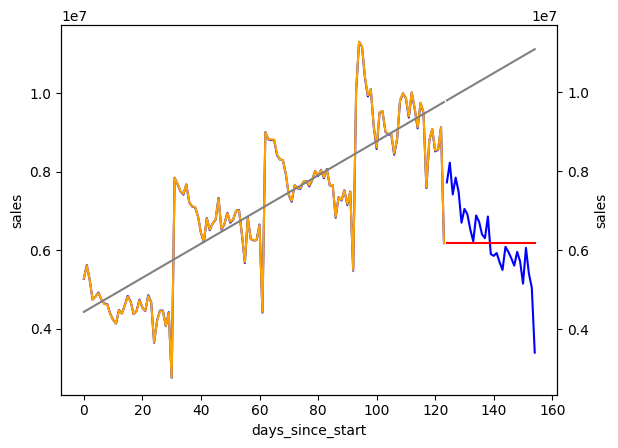

In [86]:
import seaborn as sns
sns.lineplot(x=train_x.days_since_start, y=train_y, color='blue')
ax2 = plt.twinx()
sns.lineplot(x=test_x.days_since_start, y=test_y, color='blue')
sns.lineplot(x=train_x.days_since_start, y=xgb_pipeline.predict(train_x),color='orange')
sns.lineplot(x=test_x.days_since_start, y=xgb_pipeline.predict(test_x),color='red')

sns.lineplot(x=train_x.days_since_start, y=linear_regression_pipeline.predict(train_x),color='gray')
sns.lineplot(x=test_x.days_since_start, y=linear_regression_pipeline.predict(test_x),color='gray')

In [79]:
#With pipeline
from sklearn.pipeline import FunctionTransformer

train_xy_base_df = pd.read_csv('./dataset/train.csv', index_col='id')

first_date = pd.to_datetime(train_xy_base_df['date'], format='%Y-%M-%d').min()

def change_date_to_days_since_start(X:pd.DataFrame, first_date):
    X['date'] = pd.to_datetime(X.date, format='%Y-%M-%d')

    X['days_since_start'] = ( (X['date'] - first_date) // pd.Timedelta('1D') ).astype('int32') 

    # Reset index and create a continuous 'days_since_start'
    X = X.reset_index(drop=True)
    X['days_since_start'] = X.index

    X = X.drop(columns=['date','store_nbr', 'family','onpromotion'])

    return X


#Esto no se puede porque no podria obtener el y.
#def group_by_days_since_start(X:pd.DataFrame):
#train_xy_base_df = train_xy_base_df.groupby('days_since_start',as_index=False).agg(sales=('sales','sum'))

all_y = train_xy_base_df.sales
all_x = train_xy_base_df.drop(columns='sales')

train_x, test_x , train_y, test_y = train_test_split(all_x, all_y, test_size=0.2, shuffle=False)


xgb_pipeline = Pipeline([
    ('change_date_to_days_since_start',FunctionTransformer(change_date_to_days_since_start, kw_args={'first_date':first_date})),
    ('model',XGBRegressor())
    ])
xgb_pipeline.fit(train_x,train_y)

linear_regression_pipeline = Pipeline([
    ('change_date_to_days_since_start',FunctionTransformer(change_date_to_days_since_start, kw_args={'first_date':first_date})),
    ('model',LinearRegression())
    ])
linear_regression_pipeline.fit(train_x, train_y)

end_x = linear_regression_pipeline[:1].transform(train_x)
end_x.head()

,days_since_start
0,0
1,1
2,2
3,3
4,4
